In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('NEU_Metal_Surface_Defects_Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

NEU_Metal_Surface_Defects_Data/Thumbs.db
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_122.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_297.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_217.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_249.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_291.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_238.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_37.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_32.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_25.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_42.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_198.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_165.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_270.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_87.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_160.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_213.bmp
NEU_Metal_Surface_Defects_Data/train/Crazing/Cr_274.bmp
NEU_Metal_Su

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to show images side by side
def show_images(images, titles=None, cmap='gray'):
    """Display a list of images in a row."""
    n = len(images)
    plt.figure(figsize=(4*n, 4))
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap=cmap)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()


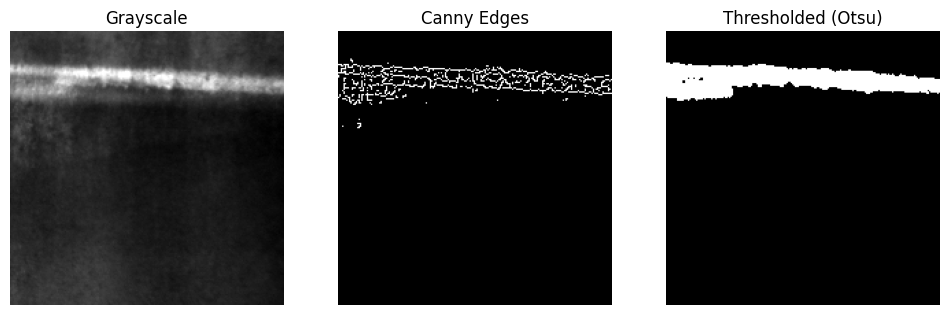

In [53]:
def edge_detection_and_threshold(image_path):
    # 1. Load image
    img = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Edge Detection (Canny)
    # Adjust thresholds (e.g., 100, 200) depending on your data
    edges = cv2.Canny(gray, threshold1=100, threshold2=100)
    
    # 3. Global or Otsu's Threshold
    #    Otsu automatically finds an optimal threshold value
    #    for separating foreground/background in a grayscale image.
    _, thresh_otsu = cv2.threshold(gray, 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Visualize the results
    show_images(
        [gray, edges, thresh_otsu],
        titles=['Grayscale', 'Canny Edges', 'Thresholded (Otsu)']
    )
    
    return edges, thresh_otsu

# Example usage
edges_result, thresh_result = edge_detection_and_threshold("NEU_Metal_Surface_Defects_Data/test/Scratches/Sc_107.bmp")


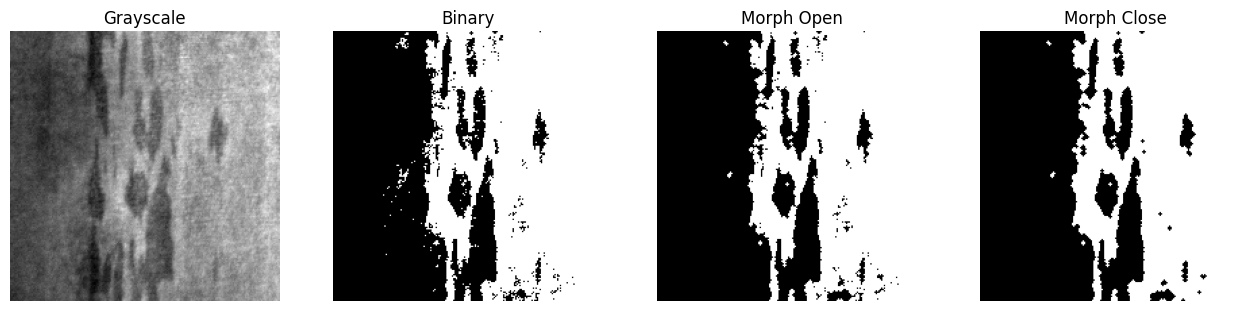

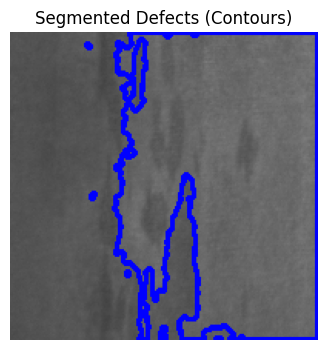

In [54]:
def basic_segmentation(image_path):
    # 1. Load image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Threshold (use Otsu or manual threshold)
    _, bin_img = cv2.threshold(gray, 0, 255, 
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Morphological operations
    #    e.g., "Opening" (erosion + dilation) to remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
    
    #    "Closing" (dilation + erosion) to fill small holes
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Visualize
    show_images(
        [gray, bin_img, opened, closed],
        titles=['Grayscale', 'Binary', 'Morph Open', 'Morph Close']
    )

    # Optionally, find contours as "segmented" defect blobs
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # to draw in color
    cv2.drawContours(segmented, contours, -1, (0, 0, 255), 2)
    
    show_images([segmented], titles=['Segmented Defects (Contours)'], cmap=None)
    
    return closed, contours

# Example usage
seg_mask, contours = basic_segmentation("NEU_Metal_Surface_Defects_Data/test/Inclusion/In_105.bmp")


In [57]:
import os
import cv2
import numpy as np

# 1) Define your source data root
SOURCE_ROOT = "./NEU_Metal_Surface_Defects_Data"  # Adjust as needed

# 2) Define your new root for preprocessed images
DEST_ROOT = "./NEU_Metal_Surface_Defects_Data_Preprocessed"

# 3) Create the same directory structure under DEST_ROOT
#    (train, valid, test, each with 6 class folders)
splits = ["train", "valid", "test"]
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]  # or os.listdir(...) if you want to auto-detect

for split in splits:
    for cls in classes:
        out_dir = os.path.join(DEST_ROOT, split, cls)
        os.makedirs(out_dir, exist_ok=True)

def preprocess_and_save_images():
    """
    For each image in the original dataset,
    1) Read it in grayscale
    2) Perform edge detection
    3) Perform threshold
    4) Concatenate channels => [gray, edges, thresh]
    5) Save to the new directory.
    """
    for split in splits:
        for cls in classes:
            src_dir = os.path.join(SOURCE_ROOT, split, cls)
            dst_dir = os.path.join(DEST_ROOT, split, cls)
            
            # List all images in the source directory
            for filename in os.listdir(src_dir):
                if not (filename.endswith('.bmp') ):
                    continue
                
                # Full path to original image
                src_path = os.path.join(src_dir, filename)
                
                # Read in grayscale
                gray = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
                if gray is None:
                    print(f"Warning: could not read {src_path}")
                    continue
                
                # --- EDGE DETECTION (Canny) ---
                edges = cv2.Canny(gray, 100, 200)
                
                # --- THRESHOLD (Otsu) ---
                #    returns bin_img with 0 or 255
                _, thresh = cv2.threshold(
                    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
                )
                
                # (Optional) morphological open or close if needed
                # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
                # opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
                # or closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
                # For now, let's stick with the basic threshold:
                morph = thresh  # or closed, etc.
                
                # --- STACK CHANNELS ---
                # We have 3 single-channel images: gray, edges, morph
                # shape: (H, W), each is uint8
                # Let's stack them into a 3-channel grayscale image: (H, W, 3)
                
                stacked = np.dstack([gray, edges, morph])  # shape => (H, W, 3)
                
                # Save result
                out_path = os.path.join(dst_dir, filename)
                # We'll save as PNG to avoid lossy compression
                cv2.imwrite(out_path, stacked)
                
    print("Preprocessing complete. Processed images saved at:", DEST_ROOT)




In [58]:
# 4) Run the function
preprocess_and_save_images()

Preprocessing complete. Processed images saved at: ./NEU_Metal_Surface_Defects_Data_Preprocessed


In [2]:
#check if gpu is enabled
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# with tf.device('/device:GPU:0'):
#     history=model.fit(dataSetGenerator,
#                       epochs=1,
#                       steps_per_epoch=self.steps_per_epoch)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
train_dir = "./NEU_Metal_Surface_Defects_Data/train"
test_dir = "./NEU_Metal_Surface_Defects_Data/test"
valid_dir = "./NEU_Metal_Surface_Defects_Data/valid"

# Data preprocessing before modeling

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


#get the images from train datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [5]:
#checking for batch size
for image_batch , labels_batch in train_generator :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32, 6)


In [6]:
#checking for class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Sample images 

In [7]:
#making functions
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    
    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

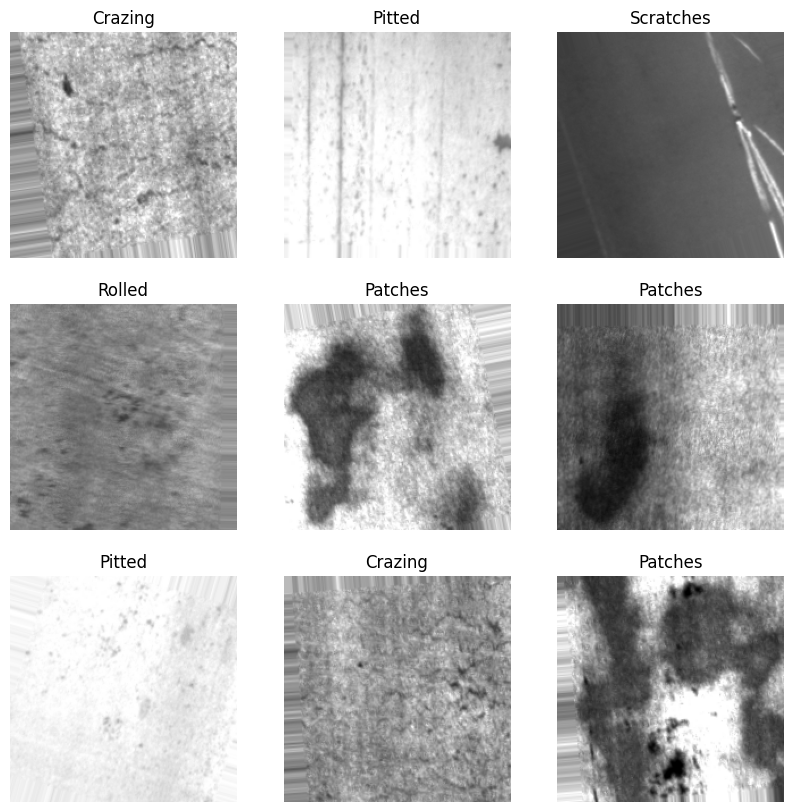

In [8]:
sample_images(train_generator, nrows=3, ncols=3)

In [9]:
image_batch

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.33186734, 0.33186734, 0.33186734],
         [0.33602738, 0.33602738, 0.33602738],
         [0.3296515 , 0.3296515 , 0.3296515 ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.33195633, 0.33195633, 0.33195633],
         [0.33598292, 0.33598292, 0.33598292],
         [0.32951808, 0.32951808, 0.32951808]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.33204526, 0.33204526, 0.33204526],
         [0.33593845, 0.33593845, 0.33593845],
         [0.32938465, 0.32938465, 0.32938465]],

        ...,

        [[0.4704259 , 0.4704259 , 0.4704259 ],
         [0.47047034, 0.47047034, 0.47047034]

# Deep learning model using CNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [11]:
model1 = Sequential([ Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')])

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737806275.792422   10424 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [12]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [13]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
with tf.device('/gpu:0'):
    
    history = model1.fit(train_generator,
                        epochs=20,
                        batch_size=32,
                        validation_data=valid_generator)

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1737806313.228232   12084 service.cc:148] XLA service 0x7cd4f8016970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737806313.228480   12084 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-25 14:58:33.255704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737806313.375600   12084 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/52 ━━━━━━━━━━━━━━━━━━━━ 3:51 5s/step - accuracy: 0.2500 - loss: 1.7568

I0000 00:00:1737806316.849675   12084 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.1870 - loss: 2.8353 - val_accuracy: 0.3750 - val_loss: 1.4448
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.4344 - loss: 1.3978 - val_accuracy: 0.6944 - val_loss: 0.7939
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.6731 - loss: 0.8813 - val_accuracy: 0.8472 - val_loss: 0.6135
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.7341 - loss: 0.7031 - val_accuracy: 0.3889 - val_loss: 1.7845
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7413 - loss: 0.6612 - val_accuracy: 0.7778 - val_loss: 0.5915
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.8277 - loss: 0.4574 - val_accuracy: 0.8611 - val_loss: 0.4023
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8367 - loss: 0.4379 - val_accuracy: 0.8333 - val_loss: 0.5103
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8263 - loss: 0.4990 - val_accuracy: 0.9306 - val

# Model 1 Evaluate

In [15]:
def plot_history(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric],"")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

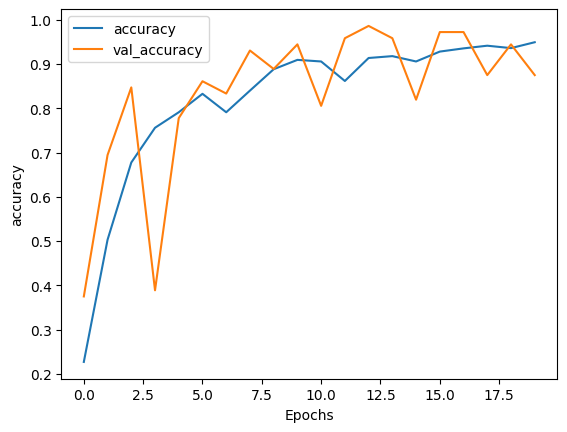

In [16]:
plot_history(history,"accuracy")

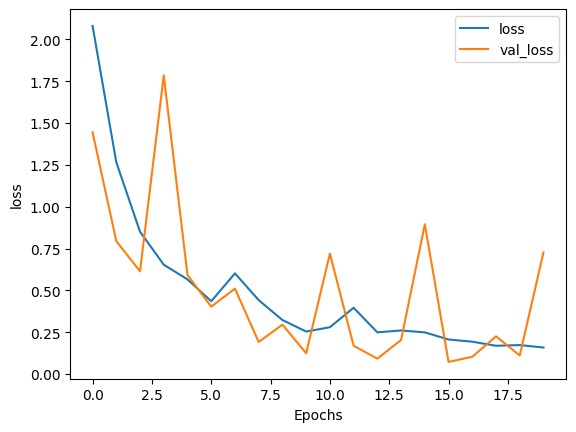

In [17]:
plot_history(history,"loss")

In [18]:
result = model1.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7912 - loss: 0.5187
Test loss, Test accuracy :  [0.5334082841873169, 0.7777777910232544]


In [19]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = (200,200,3), pooling= 'max')
model2 = Sequential([ Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')])

In [21]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model2.summary()

In [ ]:
with tf.device('/gpu:0'):

    history2 = model2.fit(train_generator,
                        epochs=20,
                        batch_size=32,
                        validation_data=valid_generator)

# Model 2 Evaluate

In [24]:
def plot_history(history, metric):
    plt.plot(history2.history[metric])
    plt.plot(history2.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_history(history, 'accuracy')

In [ ]:
plot_history(history, 'loss')

In [ ]:
result = model2.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

# Visualize Predicted Images

In [ ]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model1.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

In [ ]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model2.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

# Comparing between two models

In [ ]:
import pandas as pd

# Define the accuracy and loss values for both models
model1_accuracy = history.history['accuracy'][-1]
model1_loss = history.history['loss'][-1]
model2_accuracy = history2.history['accuracy'][-1]
model2_loss = history2.history['loss'][-1]


# Create a dictionary with the accuracy and loss values
data = {'Model': ['Model 1', 'Model 2'],
        'Accuracy': [model1_accuracy, model2_accuracy],
        'Loss': [model1_loss, model2_loss]}

df = pd.DataFrame(data)
df

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# 1) Modify your code to extract features from your trained model
#    We can define a "feature-extractor" model that stops at the second-to-last layer

feature_model = keras.Model(
    inputs=model1.input,
    outputs=model1.layers[-2].output  # e.g., the Dense(256) layer, if your final layer is Dense(6)
)

# 2) Collect features for all training images
train_features = []
train_labels = []  # optional, just to compare if you'd like

train_generator.reset()
for batch_index in range(len(train_generator)):
    images, labels = next(train_generator, (None, None))
    if images is None:
        break
    feats = feature_model.predict(images)
    train_features.append(feats)
    train_labels.append(labels)

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print("Shape of train_features:", train_features.shape)

# 3) Run k-means (assuming 6 known defect classes):
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(train_features)

# 4) Inference on new data:
test_generator.reset()
for batch_index in range(len(test_generator)):
    images, labels = next(test_generator, (None, None))
    if images is None:
        break

    # a) CNN’s softmax classification
    cnn_preds = model1.predict(images)
    top_class = np.argmax(cnn_preds, axis=1)

    # b) Feature-based clustering
    feats_test = feature_model.predict(images)
    cluster_assignments = kmeans.predict(feats_test)

    # c) Distance from cluster center 
    distances = []
    for i in range(len(cluster_assignments)):
        center = kmeans.cluster_centers_[cluster_assignments[i]]
        dist = np.linalg.norm(feats_test[i] - center)
        distances.append(dist)

    # Threshold for novelty
    DIST_THRESHOLD = 10.0  # You’ll pick or tune

    for i, dist in enumerate(distances):
        if dist > DIST_THRESHOLD:
            print(f"Image {i} might be novel! Distance to cluster center: {dist:.2f}")
            # Prompt user or handle it as you like
